In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P', "X", "*"]

In [2]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [9, 9, 9] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,10),np.logspace(-4,0,10),np.linspace(20,40,10)]
print(binning[0])
print(binning[1])
bincenters = [ get_log_bincenters(binning[0]), get_log_bincenters(binning[1]), get_lin_bincenters(binning[2]) ]
binwidths = [ get_binwidths(a) for a in binning ]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 8

[1.00000000e-05 3.59381366e-05 1.29154967e-04 4.64158883e-04
 1.66810054e-03 5.99484250e-03 2.15443469e-02 7.74263683e-02
 2.78255940e-01 1.00000000e+00]
[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]


In [3]:
len(binning[1])

10

In [4]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_fr.root")
f_preunfold = ur.open("./preunfold_fr.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_true = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
# NO TRUE DATA HERE

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])


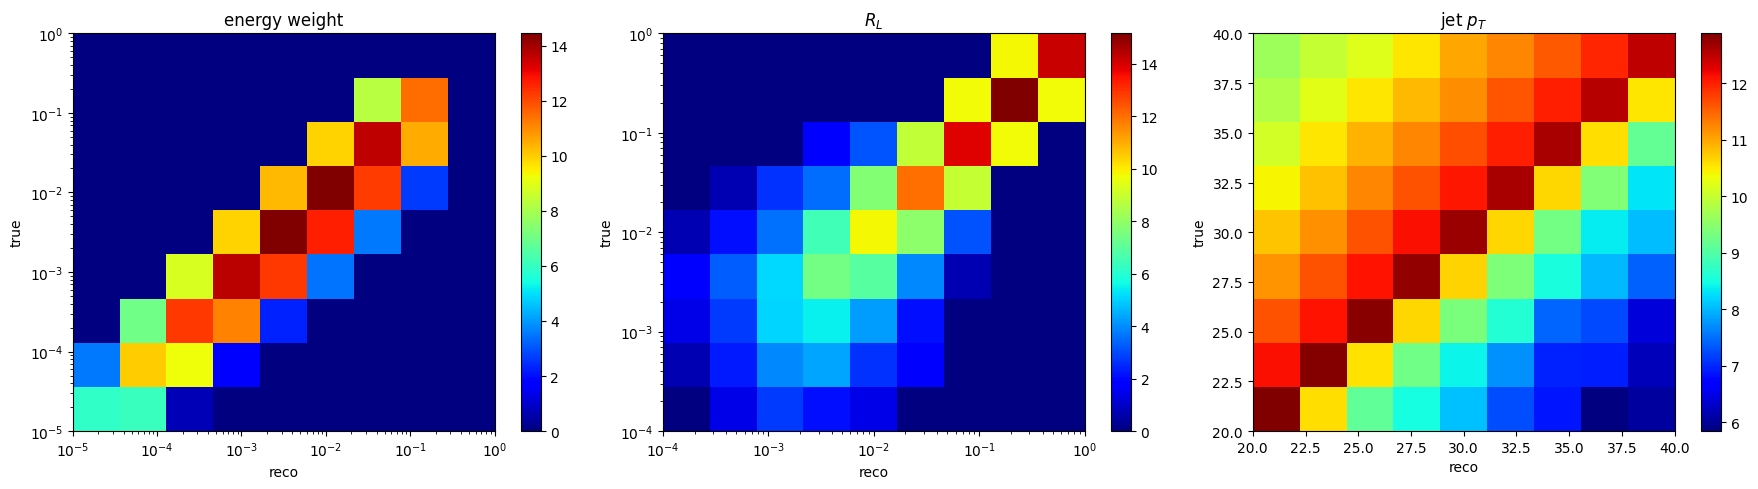

In [5]:
def FindBin(binx, biny, binz):
    assert binx < n_bins[0] and biny < n_bins [1] and binz < n_bins[2] \
            and 0 <= binx and 0 <= biny and 0 <= binz
    return binx + n_bins[0]*(biny + n_bins[1]*binz)

def FindIndex(bin_n):
    binz = bin_n // (n_bins[0] * n_bins[1])
    bin_n -= binz * (n_bins[0] * n_bins[1])

    biny = bin_n // n_bins[0]
    binx = bin_n % n_bins[0]

    return binx, biny, binz
    

matrix = f_unfolded["matrix"].values()
matrix1D = f_unfolded["matrix1D"].values()

[matrixx, matrixy, matrixz] = [np.zeros((n_bins[i], n_bins[i])) for i in range(3)]

N = n_bins[0]*n_bins[1]*n_bins[2]

for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        for k in range(n_bins[2]):

            reco_bin = FindBin(i, j, k)
            for m in range(N):
                
                binx, biny, binz = FindIndex(m)
                bincontent = matrix[reco_bin][m]

                matrixx[i][binx] += bincontent
                matrixy[j][biny] += bincontent
                matrixz[k][binz] += bincontent

matricies = [matrixx, matrixy, matrixz]

# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    h = matricies[i]
    plot = ax.pcolormesh(binning[i], binning[i], np.log(h, out=np.zeros_like(h), where=(h!=0)).T, cmap='jet')
    ax.set_title(labels[i])
    ax.set_xlabel('reco')
    ax.set_ylabel('true')

    if i in [0,1]:
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.colorbar(plot)


# Show plot
plt.tight_layout()
plt.show()

In [24]:
proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())]).T
proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())]).T

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]

theta0_G_err = proj_err(h3_gen)
theta0_S_err = proj_err(h3_reco)
theta_unknown_S_err = proj_err(h3_raw)

theta_unfolded_err = [proj_err(a) for a in h3_unfolded]

matrixify = lambda A : projectionXY(A.values()).T
matrixify_err = lambda A: projectionXY(A.errors()).T

U_unfolded = [matrixify(A) for A in h3_unfolded]
U_unfolded_err = [matrixify_err(A) for A in h3_unfolded]


In [25]:
# get total number of jets, manually inputted from 1D jet unfolding

N_jets = 11029
N_jets_err = 812

[8.400000e+01 3.820000e+02 1.344000e+03 6.640000e+03 4.349600e+04
 3.135180e+05 1.918342e+06 6.958308e+06 2.928246e+06]
(9, 3)
[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]
10
(array([8.400000e+01, 3.820000e+02, 1.344000e+03, 6.640000e+03,
       4.349600e+04, 3.135180e+05, 1.918342e+06, 6.958308e+06,
       2.928246e+06]), array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00]), <BarContainer object of 9 artists>)
9
9


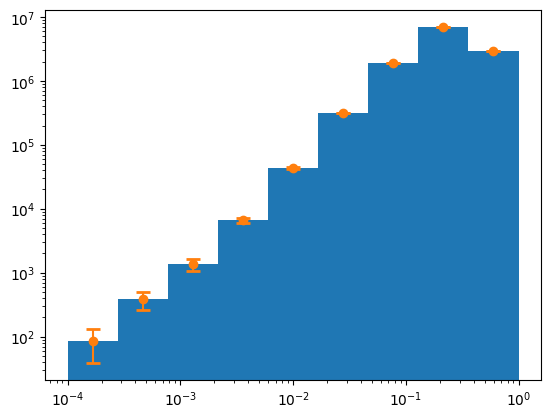

In [26]:
print(theta0_G[:,1])
print(theta0_G.shape)
print(binning[1])
print(len(binning[1]))

print(plt.hist(binning[1][:-1], binning[1], weights=theta0_G[:,1]))
print(len(binning[1][:-1]))
print(len(theta0_G_err[:,1]))
plt.errorbar(bincenters[1], theta0_G[:,1], yerr=theta0_G_err[:,1], capsize=5, capthick=2, fmt='o', linestyle="None")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [27]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][:,1])

print()

[2.90025971e+01 6.90862924e+01 2.03578895e+02 1.25939887e+03
 7.39850272e+03 4.96922864e+04 2.93559422e+05 1.04699720e+06
 4.51935687e+05]
[3.19457606e+01 8.54377928e+01 2.22128330e+02 1.34681225e+03
 7.74926869e+03 5.18256155e+04 3.04724984e+05 1.09308893e+06
 4.72708808e+05]
[3.64279021e+01 9.72249763e+01 2.34284396e+02 1.36570461e+03
 7.83754318e+03 5.26837787e+04 3.09442699e+05 1.11278260e+06
 4.81160685e+05]
[4.20543879e+01 1.06086762e+02 2.44121007e+02 1.36111623e+03
 7.85250825e+03 5.30477428e+04 3.11473817e+05 1.12109826e+06
 4.84596334e+05]
[4.81494562e+01 1.13304214e+02 2.53719680e+02 1.34697460e+03
 7.84714454e+03 5.32138728e+04 3.12401754e+05 1.12482111e+06
 4.86082281e+05]
[5.43290588e+01 1.19252809e+02 2.63613016e+02 1.32869621e+03
 7.83695781e+03 5.32963442e+04 3.12860333e+05 1.12662116e+06
 4.86778813e+05]
[6.01682492e+01 1.24162848e+02 2.73384909e+02 1.30902786e+03
 7.82661535e+03 5.33403624e+04 3.13105215e+05 1.12755778e+06
 4.87131713e+05]
[6.52591907e+01 1.28344484e

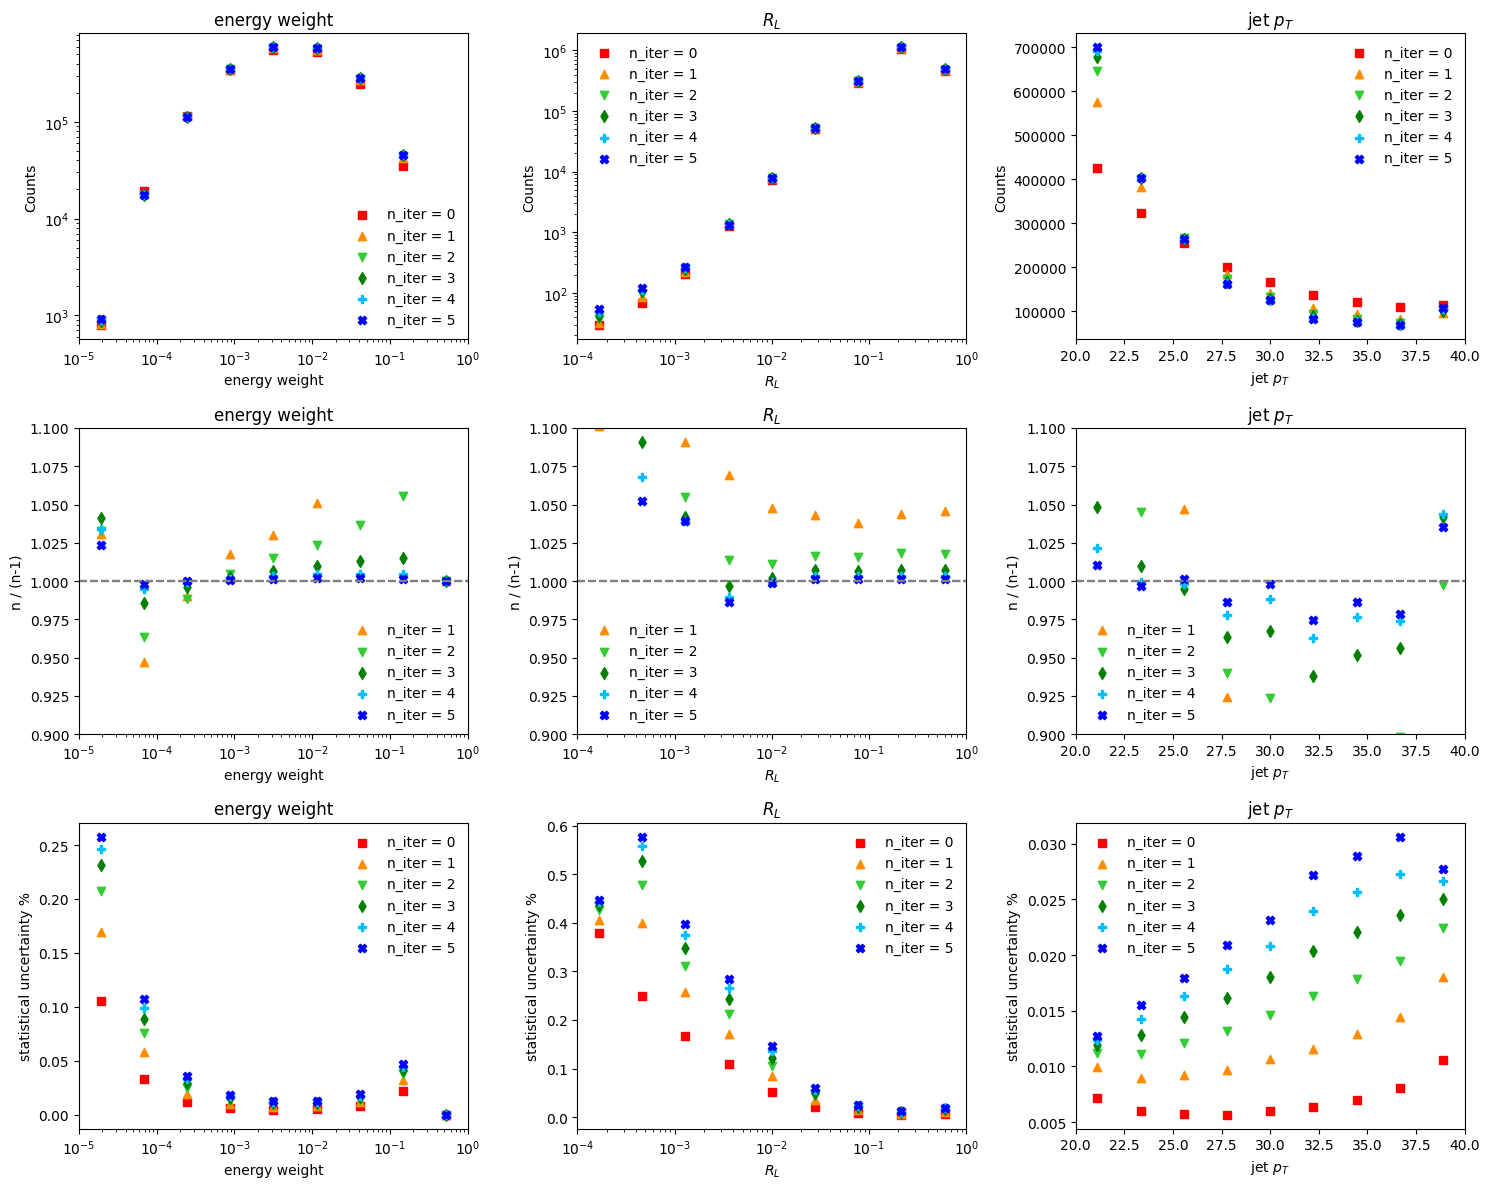

In [28]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 6

fig, axes = plt.subplots(3, 3, figsize=(15,12))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][:,i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: convergence plot (n / n - 1)
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):
    
        yvals = safe_divide(theta_unfolded[iteration][:,i] , theta_unfolded[iteration-1][:,i], filler=1)
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("n / (n-1)")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([0.9, 1.1])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 3: statistical error %
for i in range(3):
    ax = axes[2, i]

    for iteration in range(it):
        
        yvals = safe_divide(theta_unfolded_err[iteration][:,i], theta_unfolded[iteration][:,i])
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("statistical uncertainty %")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


fig.tight_layout()
plt.show()

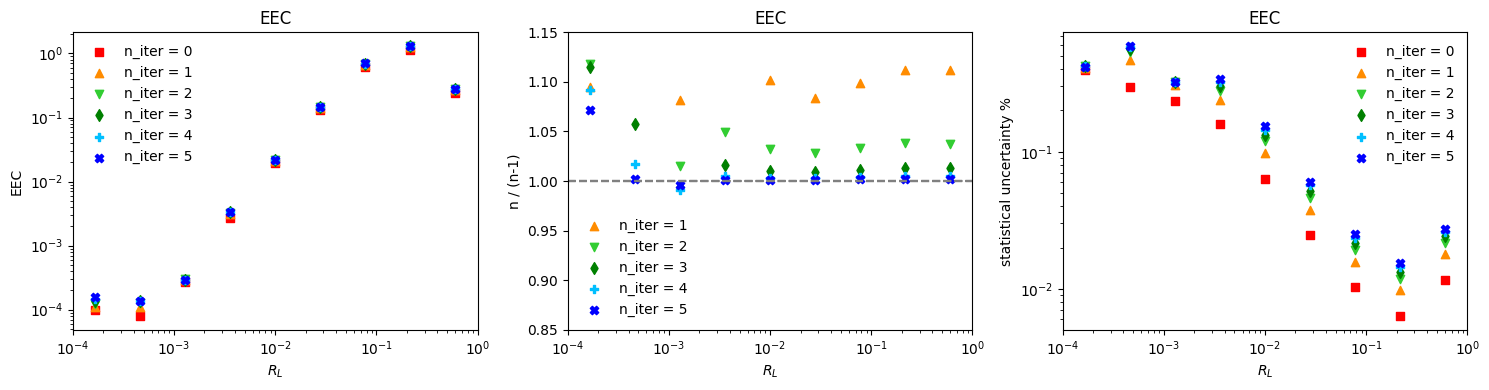

In [30]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 6

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets

# TODO propagate error from N_jets here, i dont wanna do ittttt

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0]

rl_lims = ax.set_xlim([binning[1][0], binning[1][len(binning[1])-1]])

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)
    
# COL 2: convergence plot (n / n - 1)
ax = axes[1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("statistical uncertainty %")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()
